<b><i> Important Note: </i></b> This notebook was originally written in Colab, so this will not work here. 

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.patches as pat
import cv2
import random
import torch
import numpy as np

from torchvision import models
from torchvision import transforms

from PIL import Image
from IPython.display import HTML

# Mount gdrive

<b> If you wanna run locally, you can change </b>`root='your/local/path'` <b>should work then. </b>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
root = '/gdrive/My Drive/Colab Notebooks/'

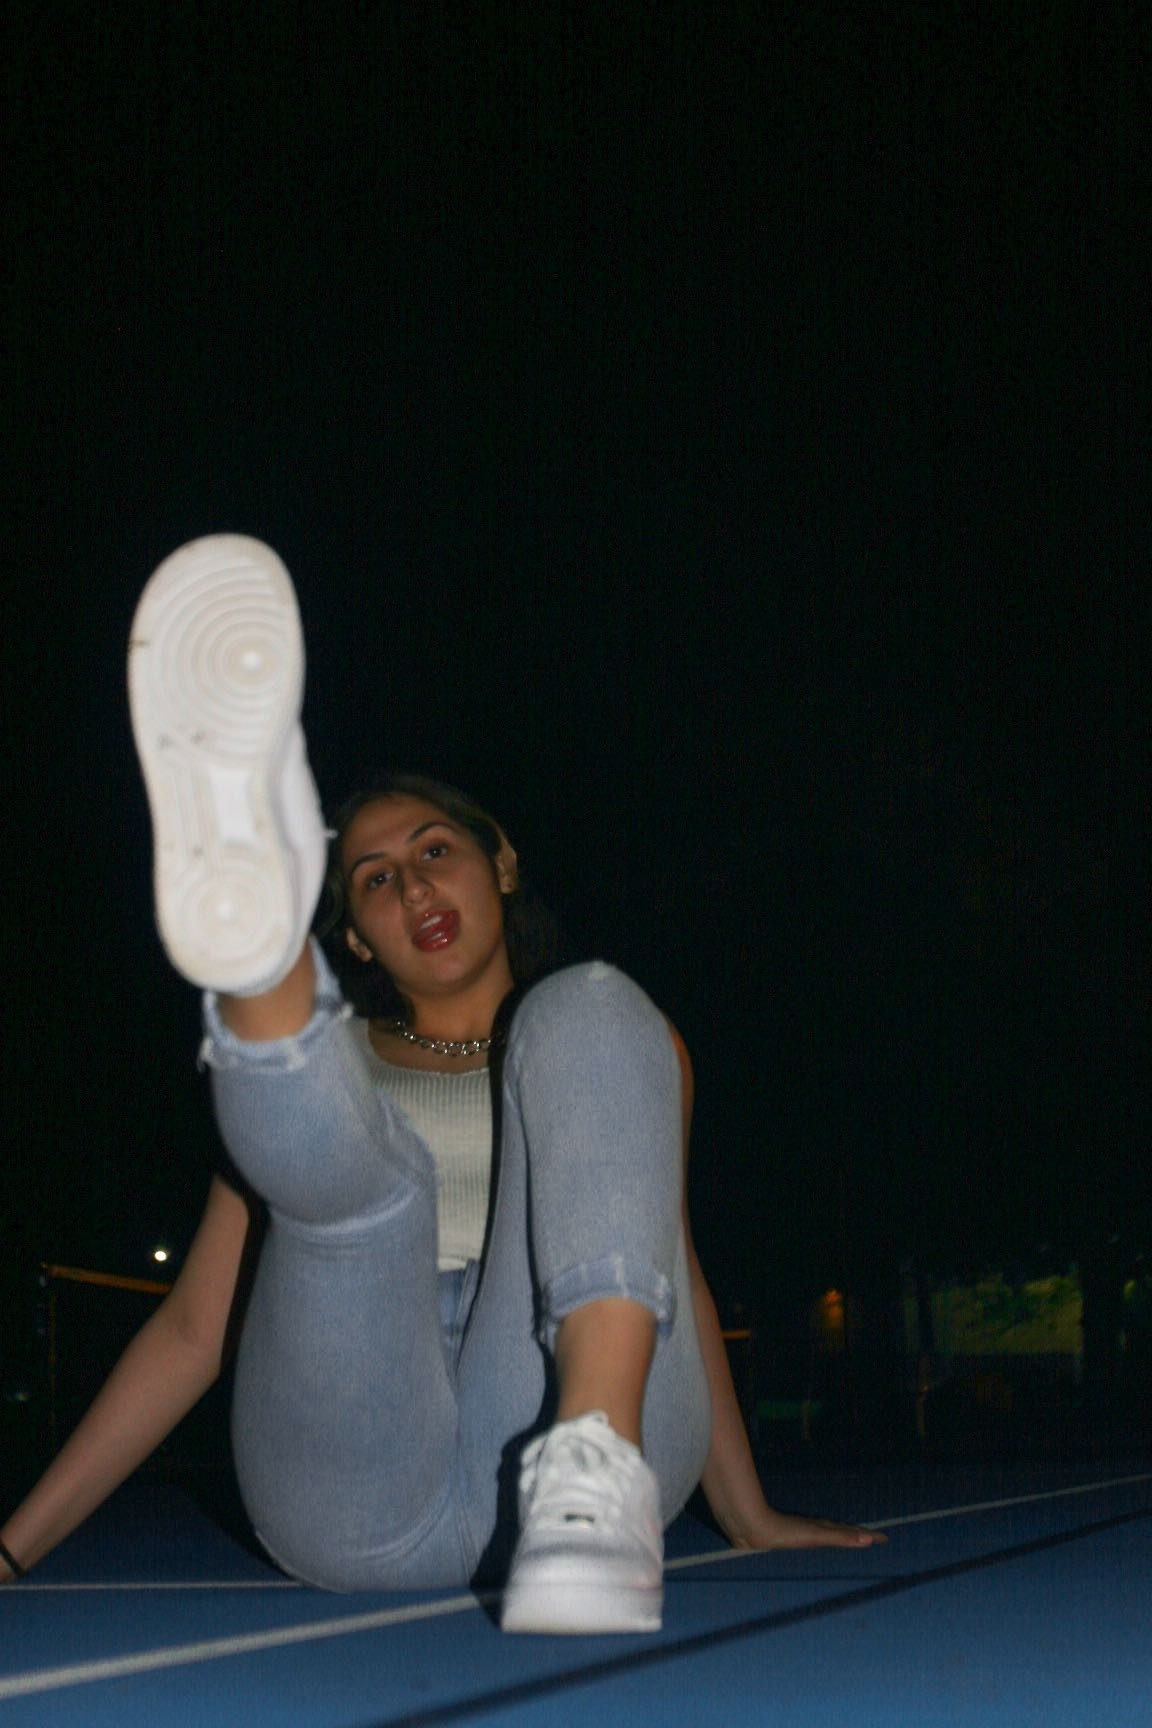

In [4]:
i = Image.open(root+'ela2.jpg')
i

# MRCNN Pretrained

In [5]:
maskrcnn = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
maskrcnn.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:04<00:00, 42.9MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(img_path, threshold):
    device = torch.device('cuda') 
    img = Image.open(img_path)
    
    # preprocess image
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0) # reshapes at 0 axis
    
    # make/ rank pred
    # pred = maskrcnn(batch_t.to(device))
    pred = maskrcnn(batch_t)
    
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    
    return img, pred, masks, pred_boxes, pred_class  

In [0]:
def get_area(c1, c2):
    return abs(c2[0] - c1[0]) * abs(c2[1] - c1[1])

def largest_bb_area(pred_boxes):
    # ret index of the largest bounding box "fg"
    bbb = 0 #biggest bounding box lmao
    bbba = 0
    for idx, i in enumerate(pred_boxes):
#         print(i)
        curra = get_area(pred_boxes[idx][0], pred_boxes[idx][1])
        if curra > bbba:
            print(f"larger {idx}, {curra} than {bbb}, {bbba}")
            bbb = idx
            bbba = curra
    return bbb

In [0]:
def show_overlay(img, mask, bb=False):
  fig, axs = plt.subplots(1, figsize=(15,15))
  if type(bb) != bool:
    rect = pat.Rectangle( (bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth = 1, edgecolor= 'r', facecolor='none' )
    axs.add_patch(rect)

  masked = np.ma.masked_where(mask == 0, mask)
  plt.imshow(img, 'gray', interpolation='none')
  plt.imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)
  plt.title("Pretrained Mask")

def show_largest_seg(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    img, pred, masks, pred_boxes, pred_class = get_prediction(img_path, threshold)
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.array(img)
    idx = largest_bb_area(pred_boxes)
    box = pred_boxes[idx]
    mask = masks[idx]
    p_cls = pred_class[idx]

    show_overlay(img, mask)

larger 0, 9030435.0 than 0, 0


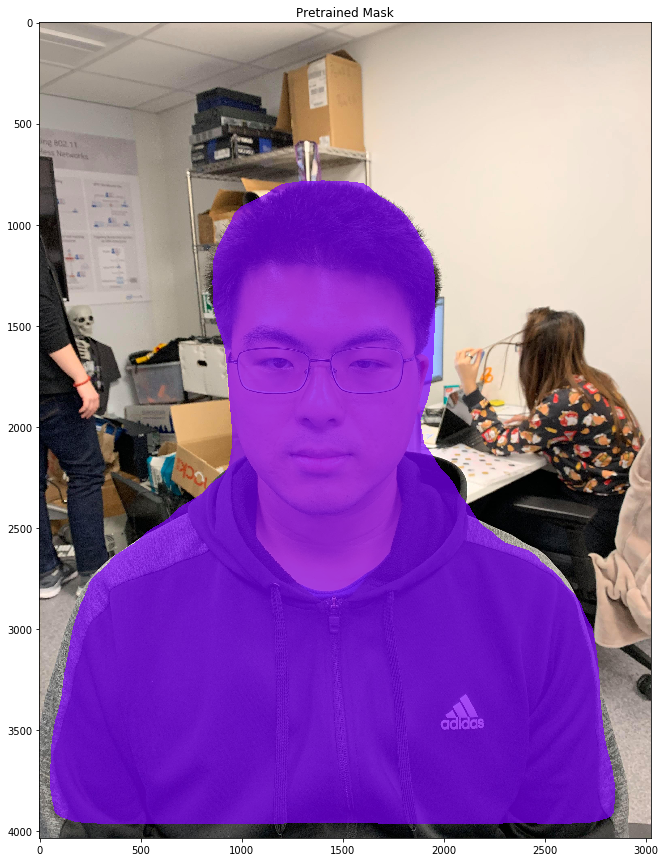

In [10]:
show_largest_seg(root+'val_imgs/albert.jpg')